In [ ]:
# ========================================
# 1. Imports
# ========================================
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ========================================
# 2. Mount Google Drive and Load Data
# ========================================
drive.mount('/content/drive')

path_tx = '/content/drive/MyDrive/synthetic_sme_transactions_processed.csv'
path_cust = '/content/drive/MyDrive/synthetic_sme_customers_processed.csv'

df_tx = pd.read_csv(path_tx)
df_cust = pd.read_csv(path_cust)

# Merge and Clean
df = pd.merge(df_tx, df_cust, on='cust_id', how='left')
df = df[np.abs(df['Amount_EUR']) >= 0.01]
df['BookingDatetime'] = pd.to_datetime(df['BookingDatetime'])
df['Amount_EUR'] = df['Amount_EUR'].round(2)
df['Week'] = df['BookingDatetime'].dt.isocalendar().week
df['Month'] = df['BookingDatetime'].dt.month

print(f"✅ Combined dataset shape: {df.shape}")
print(f"✅ Unique SMEs: {df['cust_id'].nunique()}")

Mounted at /content/drive
✅ Combined dataset shape: (1047635, 20)
✅ Unique SMEs: 498



--- Descriptive Statistics for Transaction Amounts (EUR) ---
count    1047635.00
mean        1573.24
std        16332.90
min      -149386.73
25%           34.40
50%          136.19
75%          600.37
max      3997185.92
Name: Amount_EUR, dtype: float64

--- Debit vs Credit Counts ---
D_C
D    535917
C    511718
Name: count, dtype: int64

--- Transactions per Customer ---
count      498.00
mean      2103.68
std       4386.92
min         12.00
25%        396.00
50%        895.00
75%       1890.50
max      54620.00
Name: Amount_EUR, dtype: float64

Skewness: 113.20, Kurtosis: 23045.50


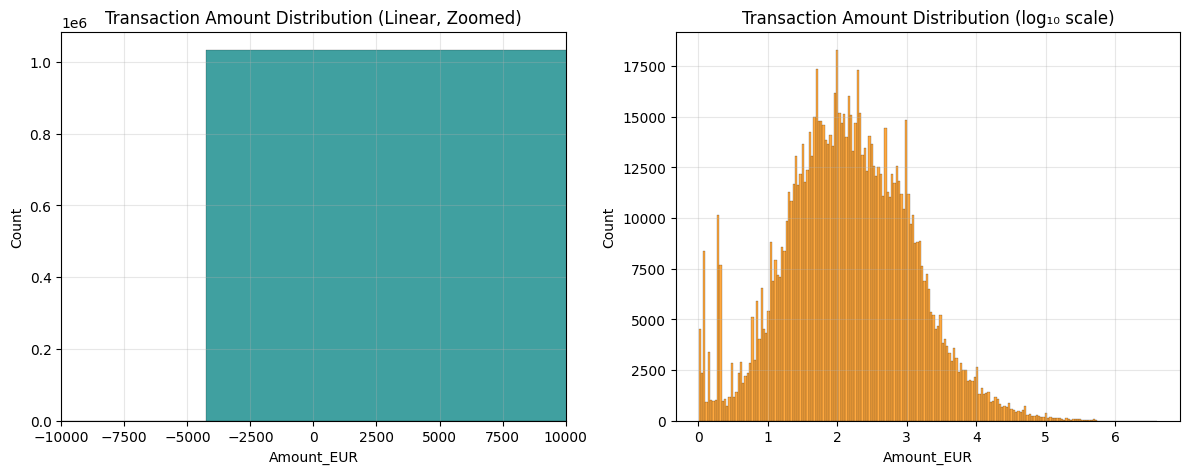

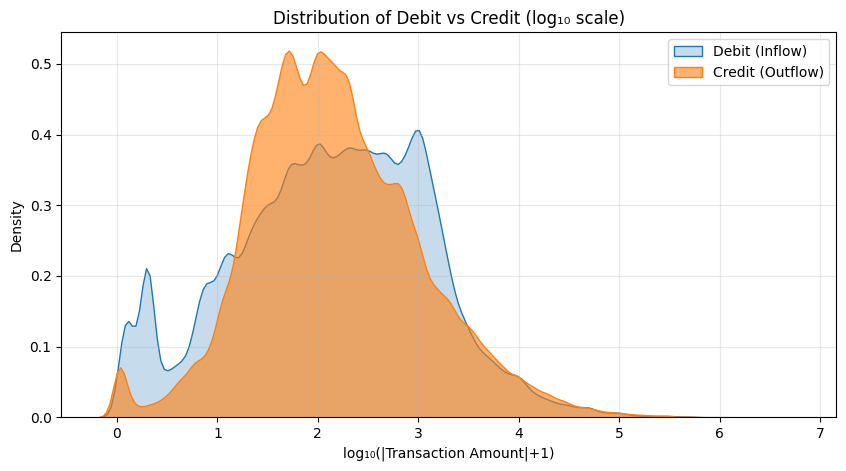

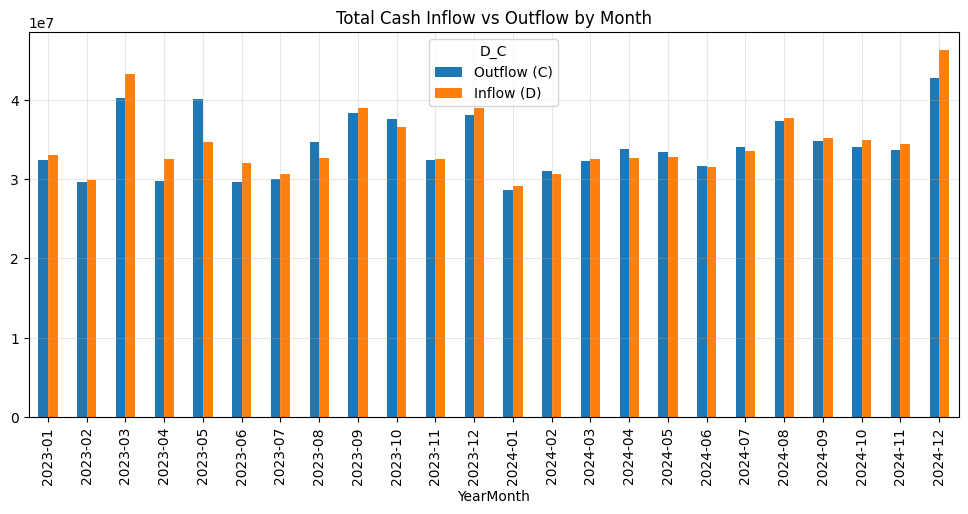

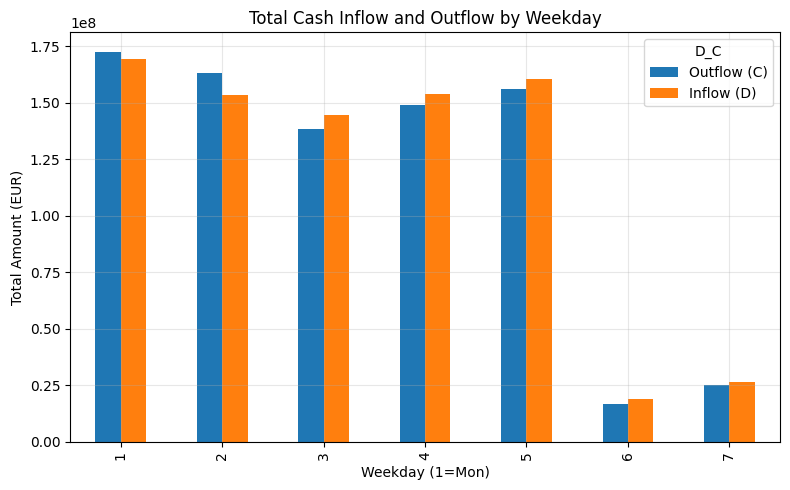

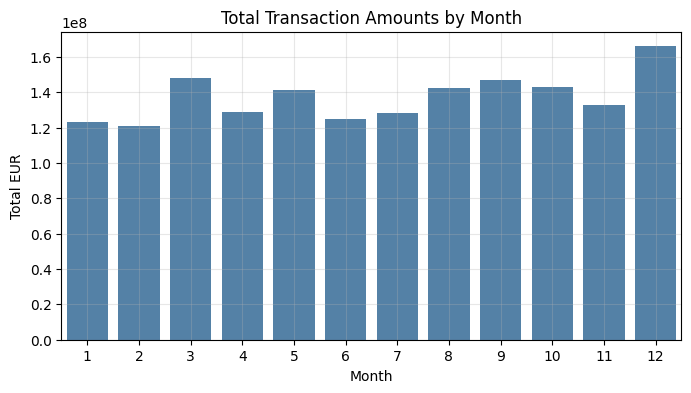

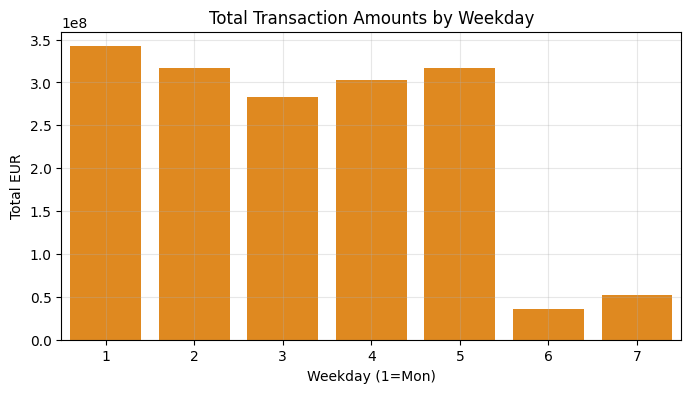

In [4]:
# ========================================
# 3. Exploratory Data Analysis
# ========================================

print("\n--- Descriptive Statistics for Transaction Amounts (EUR) ---")
desc = df['Amount_EUR'].describe().round(2)
print(desc)

print("\n--- Debit vs Credit Counts ---")
print(df['D_C'].value_counts())

print("\n--- Transactions per Customer ---")
tx_per_customer = df.groupby('cust_id')['Amount_EUR'].count()
print(tx_per_customer.describe().round(2))

print(f"\nSkewness: {skew(df['Amount_EUR']):.2f}, Kurtosis: {kurtosis(df['Amount_EUR']):.2f}")

# (a) Distribution plots (linear + log10 scale)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['Amount_EUR'], bins=200, color='teal')
plt.title('Transaction Amount Distribution (Linear, Zoomed)')
plt.xlim(-10000, 10000)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(np.log10(np.abs(df['Amount_EUR'])+1), bins=200, color='darkorange')
plt.title('Transaction Amount Distribution (log₁₀ scale)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (b) Debit vs Credit log distribution
plt.figure(figsize=(10,5))
sns.kdeplot(np.log10(df[df['D_C']=='D']['Amount_EUR'].abs()+1), label='Debit (Inflow)', fill=True)
sns.kdeplot(np.log10(df[df['D_C']=='C']['Amount_EUR'].abs()+1), label='Credit (Outflow)', fill=True, alpha=0.6)
plt.title('Distribution of Debit vs Credit (log₁₀ scale)')
plt.xlabel('log₁₀(|Transaction Amount|+1)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# (c) Monthly inflows/outflows
df['YearMonth'] = df['BookingDatetime'].dt.to_period('M')
monthly_flows = df.groupby(['YearMonth', 'D_C'])['Amount_EUR'].sum().unstack(fill_value=0)
monthly_flows.rename(columns={'D':'Inflow (D)', 'C':'Outflow (C)'}).plot(kind='bar', figsize=(12,5))
plt.title('Total Cash Inflow vs Outflow by Month')
plt.grid(alpha=0.3)
plt.show()

# (d) Total Cash Inflow vs Outflow by Weekday
weekday_flows = df.groupby(['WeekDay', 'D_C'])['Amount_EUR'].sum().unstack(fill_value=0)
weekday_flows = weekday_flows.rename(columns={'D':'Inflow (D)', 'C':'Outflow (C)'})
weekday_flows.plot(kind='bar', figsize=(8,5))
plt.title('Total Cash Inflow and Outflow by Weekday')
plt.xlabel('Weekday (1=Mon)')
plt.ylabel('Total Amount (EUR)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (e) Total Transaction Amounts by Month (All Transactions Combined)
monthly_totals = df.groupby('Month')['Amount_EUR'].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=monthly_totals.index, y=monthly_totals.values, color='steelblue')
plt.title('Total Transaction Amounts by Month')
plt.xlabel('Month')
plt.ylabel('Total EUR')
plt.grid(alpha=0.3)
plt.show()

# (f) Total Transaction Amounts by Weekday
weekday_totals = df.groupby('WeekDay')['Amount_EUR'].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_totals.index, y=weekday_totals.values, color='darkorange')
plt.title('Total Transaction Amounts by Weekday')
plt.xlabel('Weekday (1=Mon)')
plt.ylabel('Total EUR')
plt.grid(alpha=0.3)
plt.show()

In [5]:
# ========================================
# 4. Compute Daily Net Cash Flow per Customer
# ========================================
df['flow'] = df.apply(lambda x: x['Amount_EUR'] if x['D_C'] == 'D' else -x['Amount_EUR'], axis=1)

daily_cashflow = (
    df.groupby(['cust_id', pd.Grouper(key='BookingDatetime', freq='D')])['flow']
      .sum()
      .reset_index()
      .rename(columns={'flow': 'net_flow'})
)

print(f"Daily cashflow shape: {daily_cashflow.shape}")
print(daily_cashflow.head())

Daily cashflow shape: (140809, 3)
                                             cust_id BookingDatetime  net_flow
0  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-01     -0.02
1  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-08      2.00
2  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-16    280.68
3  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-17      0.40
4  00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...      2023-01-27     15.04


In [6]:
# ========================================
# 5. Winsorize Outliers (Top/Bottom 1%)
# ========================================
def winsorize_outliers(series, limits=(0.01, 0.01)):
    return pd.Series(winsorize(series, limits=limits), index=series.index)

daily_cashflow['net_flow_wins'] = (
    daily_cashflow.groupby('cust_id')['net_flow']
    .transform(lambda x: winsorize_outliers(x, limits=(0.01, 0.01)))
)

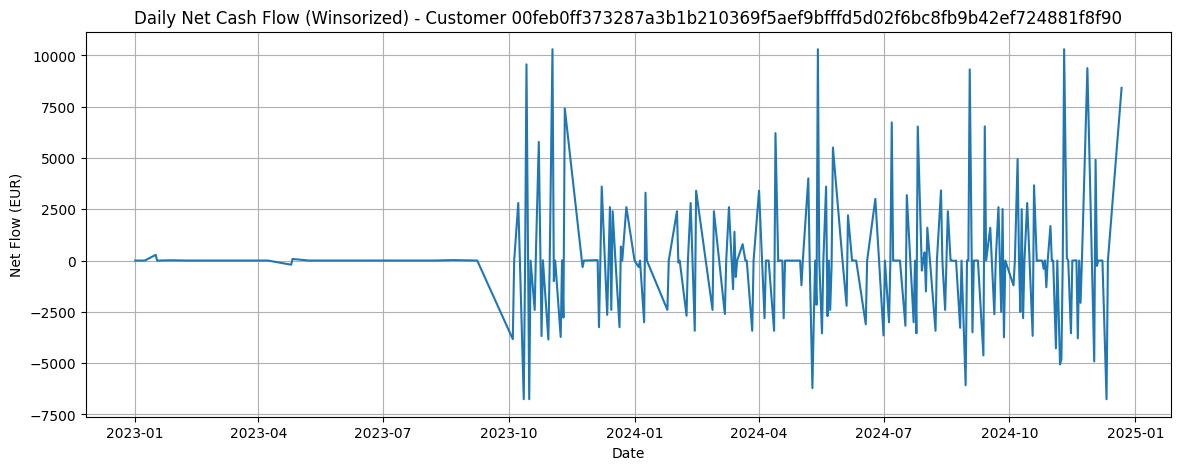

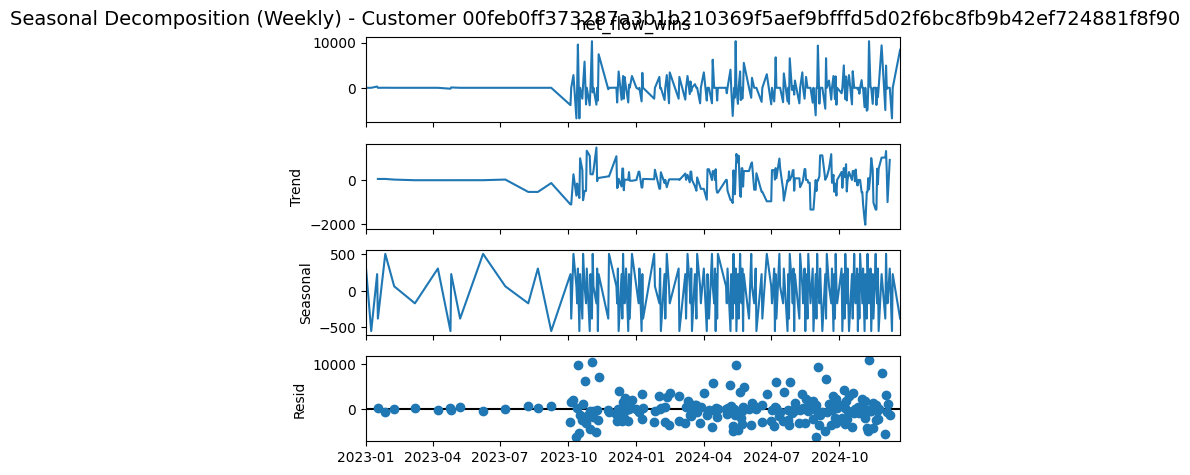

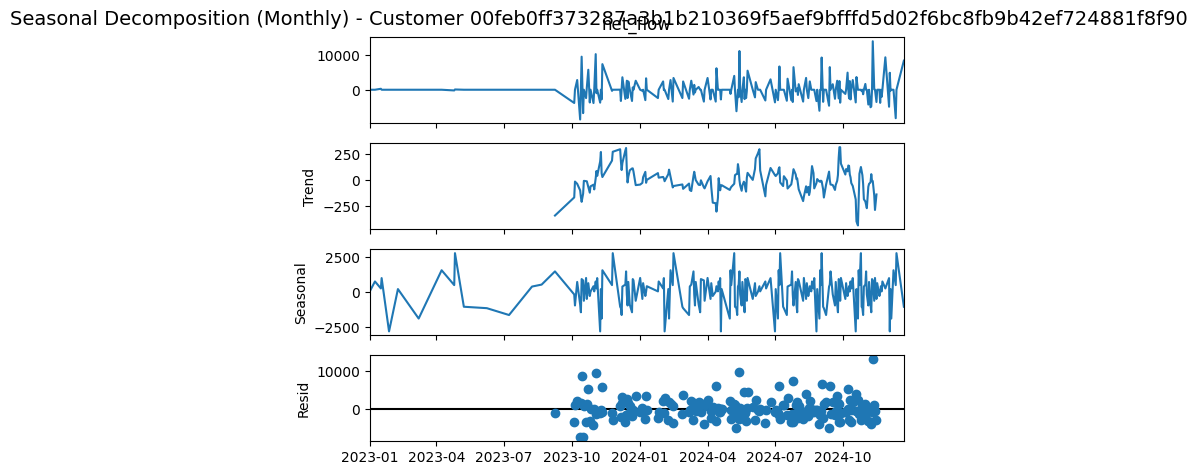

In [8]:
# ========================================
# 6. Analyze One Customer Example
# ========================================
cust_example = daily_cashflow['cust_id'].iloc[0]
df_cust = daily_cashflow[daily_cashflow['cust_id'] == cust_example].set_index('BookingDatetime')

plt.figure(figsize=(14,5))
plt.plot(df_cust['net_flow_wins'])
plt.title(f'Daily Net Cash Flow (Winsorized) - Customer {cust_example}')
plt.xlabel('Date')
plt.ylabel('Net Flow (EUR)')
plt.grid(True)
plt.show()

# Decomposition (Weekly)
result = seasonal_decompose(df_cust['net_flow_wins'].dropna(), model='additive', period=7)
result.plot()
plt.suptitle(f'Seasonal Decomposition (Weekly) - Customer {cust_example}', fontsize=14)
plt.show()

# Period=30 means monthly seasonality
result2 = seasonal_decompose(df_cust['net_flow'].dropna(), model='additive', period=30)
result2.plot()
plt.suptitle(f'Seasonal Decomposition (Monthly) - Customer {cust_example}', fontsize=14)
plt.show()

In [9]:
# ========================================
# 7. Stationarity (ADF Test)
# ========================================
def adf_test(series, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\nADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary ✅" if result[1] <= 0.05 else "  Non-stationary ❌")
    return result[1]

pval = adf_test(df_cust['net_flow_wins'], name=f"Customer {cust_example}")
if pval > 0.05:
    series_used = df_cust['net_flow_wins'].diff().dropna()
    print("➡ Differenced series used for modeling.")
else:
    series_used = df_cust['net_flow_wins']


ADF Test for Customer 00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8fb9b42ef724881f8f90:
  ADF Statistic: -8.5087
  p-value: 0.0000
  Stationary ✅


In [13]:
# ========================================
# 8. ARIMA Model Fitting
# ========================================
from statsmodels.tsa.arima.model import ARIMA
# Try simple ARIMA(1,0,1) as a starting point (we’ll tune later)
# d=0 means no differences, assuming stationary base series
model = ARIMA(df_cust['net_flow'], order=(1,0,1))
model_fit = model.fit()

print("\nModel Summary:")
print(model_fit.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:               net_flow   No. Observations:                  221
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2060.481
Date:                Thu, 13 Nov 2025   AIC                           4128.963
Time:                        21:33:04   BIC                           4142.555
Sample:                             0   HQIC                          4134.451
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0074      6.161     -0.813      0.416     -17.083       7.068
ar.L1          0.4900      0.045     10.855      0.000       0.402       0.578
ma.L1         -1.0000      0.086    

In [14]:
# ========================================
# 9. SARIMA Grid Search
# ========================================
def sarima_grid_search(series, seasonal_period=7):
    best_aic = np.inf
    best_model = None
    best_params = None
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(series, order=param, seasonal_order=param_seasonal,
                              enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = res
                    best_params = (param, param_seasonal)
            except:
                continue
    return best_model, best_params, best_aic

best_model, best_params, best_aic = sarima_grid_search(series_used)
print(f"\n✅ Best SARIMA params: {best_params} | AIC: {best_aic:.2f}")


✅ Best SARIMA params: ((1, 0, 1), (1, 1, 1, 7)) | AIC: 3848.85


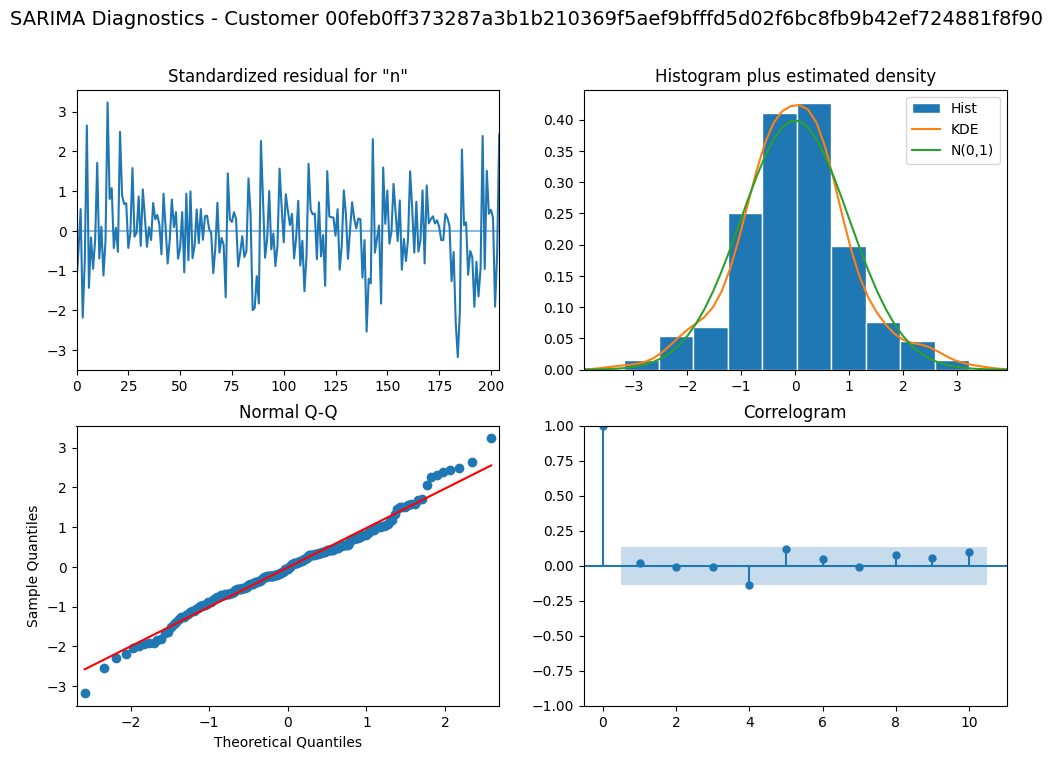

In [15]:
# ========================================
# 10. Model Diagnostics
# ========================================
best_model.plot_diagnostics(figsize=(12,8))
plt.suptitle(f"SARIMA Diagnostics - Customer {cust_example}", fontsize=14)
plt.show()


Model Performance on last 30 days:
  MAE = 2570.32
  RMSE = 3975.15


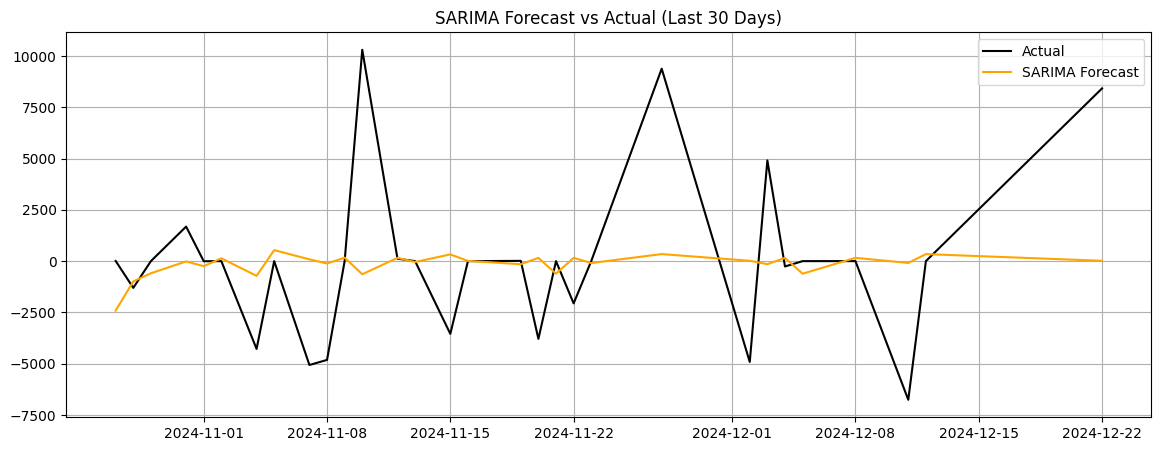

In [16]:
# ========================================
# 10. Train-Test Evaluation
# ========================================
train = series_used[:-30]
test = series_used[-30:]
forecast = best_model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nModel Performance on last 30 days:\n  MAE = {mae:.2f}\n  RMSE = {rmse:.2f}")

plt.figure(figsize=(14,5))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual (Last 30 Days)')
plt.legend()
plt.grid(True)
plt.show()

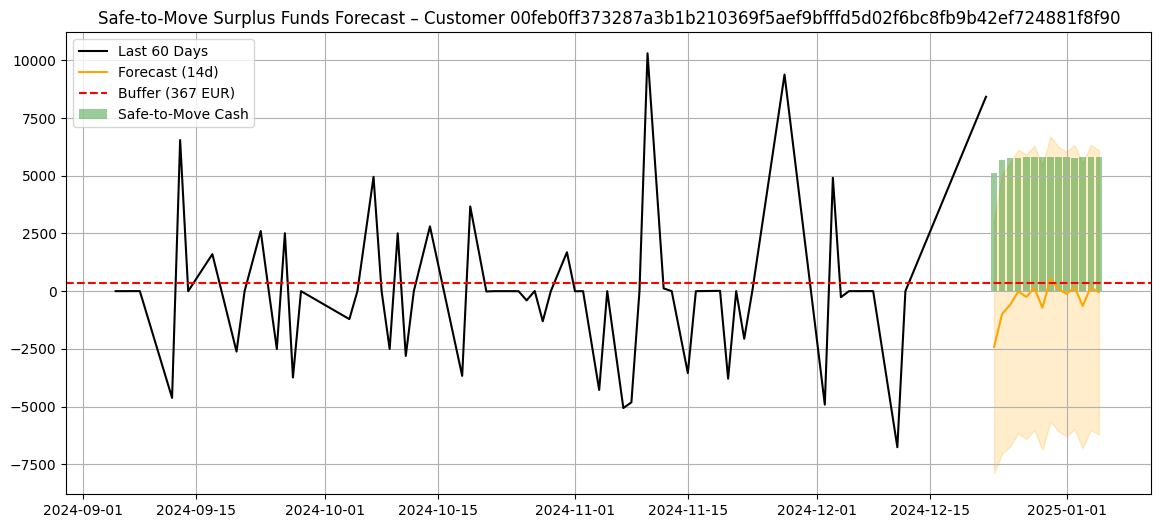


Overall Model Performance for Customer 00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8fb9b42ef724881f8f90:
  MAE: 2570.32
  RMSE: 3975.15
  Target met (RMSE ≤ 1000 EUR): False


In [17]:
# ========================================
# 11. Safe-to-Move Forecast
# ========================================
def calculate_safe_to_move(df_customer, sarima_model, forecast_horizon=14, liquidity_buffer_ratio=0.2):
    df_customer = df_customer.set_index('BookingDatetime').sort_index()
    avg_abs_flow = df_customer['net_flow_wins'].abs().mean()
    liquidity_buffer = liquidity_buffer_ratio * avg_abs_flow

    forecast = sarima_model.get_forecast(steps=forecast_horizon)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.index = pd.date_range(df_customer.index[-1], periods=forecast_horizon+1, freq='D')[1:]

    forecast_df['Safe_to_Move'] = np.maximum(forecast_df['Forecast'] - liquidity_buffer - forecast_df.iloc[:,0], 0)
    return forecast_df, liquidity_buffer

forecast_df, liquidity_buffer = calculate_safe_to_move(df_cust.reset_index(), best_model, 14, 0.2)

plt.figure(figsize=(14,6))
plt.plot(df_cust.index[-60:], df_cust['net_flow_wins'].iloc[-60:], color='black', label='Last 60 Days')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='orange', label='Forecast (14d)')
plt.fill_between(forecast_df.index, forecast_df.iloc[:,0], forecast_df.iloc[:,1], color='orange', alpha=0.2)
plt.bar(forecast_df.index, forecast_df['Safe_to_Move'], alpha=0.4, color='green', label='Safe-to-Move Cash')
plt.axhline(y=liquidity_buffer, color='red', linestyle='--', label=f'Buffer ({liquidity_buffer:.0f} EUR)')
plt.title(f"Safe-to-Move Surplus Funds Forecast – Customer {cust_example}")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nOverall Model Performance for Customer {cust_example}:")
print(f"  MAE: {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  Target met (RMSE ≤ 1000 EUR): {rmse <= 1000}")